In [105]:
from __future__ import print_function
import torch
from torch.autograd import Variable, Function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import data
from torchtext import datasets
from torchtext.vocab import GloVe, CharNGram

import scipy.io as sio
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from minimax_entropy import MinimaxEntropyEstimator

# https://github.com/pytorch/text
# http://cogcomp.org/Data/QA/QC/
# note, increasing dim decreases loss (we can see that disimilar things in hd space are very far away)

In [106]:
n_samples = 50
batch_size = 100
learning_rate = 1
dim = 1000
classes = 6
class_dict = {'loc':0, 'hum':1, 'num':2, 'abbr':3, 'enty':4, 'desc':5}
word_dict = {}
alph = 'abcdefghijklmnopqrstuvwxyz#.:-'
letter_vecs = 2 * (np.random.randn(len(alph), N) < 0) - 1

entro = MinimaxEntropyEstimator('poly_coeff_entro.mat', n_samples, gpu=True)

In [123]:
def read_data(url):
    texts, labels = [], []
    with open(url) as f:
        content = f.readlines()
        content = list(set(content))
        for i in range(len(content)):
            l = content[i].lower()
            l = l.replace('\'', '')
            l = l.replace('``', '')
            l = l.replace('?', '')
            l = l.split(' ')
            l = filter(None, l)
            
            label = l[0].split(':')[0]
            l = l[1:len(l)-1]
            texts.append(l)
            labels.append(class_dict[label])
    return texts, labels

def batch_data(texts, labels, batch_size):
    text_batches, label_batches = [], []
    previ = 0
    for i in range(batch_size,len(texts), batch_size):
        text_batches.append(texts[previ:i])
        label_batches.append(np.array(labels[previ:i]))
        previ = i
    remainder = len(texts)% batch_size
    print ('remainder', remainder)
    print ('texts length', len(text_batches))
    if len(texts) % batch_size != 0:
        ri = len(texts)-remainder
        text_batches.append(texts[ri:])
        label_batches.append(np.array(labels[ri:]))
    return text_batches, label_batches

# def encode_text(texts):
#     sentences = np.zeros((len(texts), dim))
#     for i in range(len(texts)):
#         s_vec = np.ones(dim)
#         for j in range(len(texts[i])):
#             # we try this first before we build from character space to word space
#             if texts[i][j] not in word_dict:
#                 word_dict[texts[i][j]] = 2 * (np.random.randn(dim) < 0) - 1
#             s_vec = s_vec*np.roll(word_dict[texts[i][j]], j)
#         sentences[i] = s_vec
#     return sentences



In [124]:
testurl = 'data/raw/TREC_10.label'
trainurl = 'data/raw/train_5500.label'
test_texts, test_labels = read_data(testurl)
train_texts, train_labels = read_data(trainurl)

test_batches, ytest_batches = batch_data(test_texts, test_labels, batch_size)
train_batches, y_batches = batch_data(train_texts, train_labels, batch_size)

# test_vecs = encode_text(test_texts)
# train_vecs = encode_text(train_texts)
test_vecs = [encode_text(text) for text in test_batches]
train_vecs = [encode_text(text) for text in train_batches]

remainder 0
texts length 4
remainder 82
texts length 53


In [125]:
print(train_batches[0])
print(y_batches[0])

[['what', 'was', 'mark', 'johnson', 'referring', 'to', 'when', 'he', 'said', ':', 'i', 'still', 'can', 't', 'believe', 'it-', 'we', 'beat', 'the', 'russians'], ['what', 'country', 'imposed', 'the', 'berlin', 'blockade', 'in', '1948'], ['what', 'was', 'the', 'species', 'of', 'winnie', 'the', 'pooh'], ['how', 'wide', 'is', 'the', 'atlantic', 'ocean'], ['mississippi', 'is', 'nicknamed', 'what'], ['what', 'room', 'did', 'w.c.', 'fields', 'keep', 'his', 'library', 'in'], ['who', 'is', 'the', 'composer', 'of', 'canon', 'in', 'd', 'major'], ['describe', 'the', 'long', 'march'], ['what', 'was', 'the', 'bridge', 'of', 'san', 'luis', 'rey', 'made', 'of'], ['what', 'is', 'the', 'zodiac', 'sign', 'for', 'august', '14'], ['what', 'country', 'is', 'the', 'origin', 'of', 'the', 'band', 'the', 'creeps'], ['what', 'asian', 'leader', 'was', 'known', 'as', 'the', 'little', 'brown', 'saint'], ['what', 'famed', 'river', 'was', 'hernando', 'de', 'soto', 'the', 'first', 'european', 'to', 'see'], ['who', 'sin

In [109]:
def _g(p, q):
    if (q.data == 1).all():
        return - torch.log(p + eps) / _denom
    return - torch.log(1 - p + eps) / _denom
    
def cross_entro_loss(dist_p, dist_q):
    H = Variable(torch.zeros(1)).double()
    for i in range(len(dist_p)):
        H += _g(dist_p[i], dist_q[i])
    return H
    
    
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )

# loss_fn = torch.nn.MSELoss(size_average=False)
loss_fn = cross_entro_loss


In [104]:
_denom = np.log(np.e)
eps = 1e-12

def _g(p, q):
    if (q.data == 1).all():
        return - torch.log(p + eps) / _denom
    return - torch.log(1 - p + eps) / _denom
    
def cross_entro_loss(dist_p, dist_q):
    H = Variable(torch.zeros(1)).double()
    for i in range(len(dist_p)):
        H += _g(dist_p[i], dist_q[i])
    return H

def accuracy(yhat, labels):
    maxs, indices = torch.max(torch.exp(yhat), 1)
    for i in range(y.size()):
        

model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )

loss_fn = cross_entro_loss

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = batch_size, dim, 100, 6

learning_rate = 1e-4
losses = []
accuracies = []

batch_idx = 0

x = Variable(torch.FloatTensor(train_vecs[batch_idx]), requires_grad=True)

yhot = np.zeros((y_batches[batch_idx].shape[0], D_out))
yhot[[idx for idx in range(yhot.shape[0])], y_batches[batch_idx]] = 1
y = Variable(torch.DoubleTensor(yhot), requires_grad=False)

for epoch in range(10):
    y_pred = model(x)

    loss = Variable(torch.zeros(1), requires_grad=True).double()
    for i in range(len(train_vecs[batch_idx])):
        yhat = y_pred[i] + y_pred[i].min().abs()
        norm = torch.norm(yhat, 2)
        yhat = yhat.div(norm)
        yhat = yhat.div(yhat.sum())
        yhat = yhat.double()

        loss += loss_fn(yhat, y[i])

    
    print ('epoch', str(epoch), 'loss', loss.data[0])
    
    losses.append(loss.data[0])
    
    model.zero_grad()
    loss.backward()

    for param in model.parameters():
        param.data -= learning_rate * param.grad.data


epoch 0 loss 14041.3473881
epoch 1 loss 6107.76133266
epoch 2 loss 5659.45916929
epoch 3 loss 5594.59833694
epoch 4 loss 5566.43250907
epoch 5 loss 5538.4982495
epoch 6 loss 5506.95097953
epoch 7 loss 5469.35862698
epoch 8 loss 5422.42187241
epoch 9 loss 5341.80638848
epoch 10 loss 5216.24056382
epoch 11 loss 5097.9389819
epoch 12 loss 4956.52664968
epoch 13 loss 4791.19585034
epoch 14 loss 4550.72342295
epoch 15 loss 4392.7484402
epoch 16 loss 4097.06864261
epoch 17 loss 4411.71983071
epoch 18 loss 3819.08684796
epoch 19 loss 4144.6363096
epoch 20 loss 3974.57358793
epoch 21 loss 3971.03717005
epoch 22 loss 3389.88297621
epoch 23 loss 3630.92359439
epoch 24 loss 3185.18851465
epoch 25 loss 3583.5710262
epoch 26 loss 3186.11296981
epoch 27 loss 3671.11579543
epoch 28 loss 3155.09699747
epoch 29 loss 3521.79729935
epoch 30 loss 3179.94370779
epoch 31 loss 3072.65998912
epoch 32 loss 3102.35215535
epoch 33 loss 3052.60680786
epoch 34 loss 2893.02916827
epoch 35 loss 2947.03834816
epoch 3

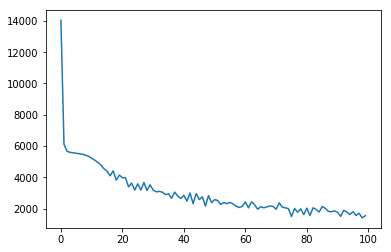

In [110]:
plt.figure()
plt.plot(losses)
plt.show()

In [ ]:
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, H),
          torch.nn.ReLU(),
          torch.nn.Linear(H, D_out),
        )

model = model.cuda()

loss_fn = entro.cross_entro_loss

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = batch_size, dim, 100, 6

learning_rate = 1e-4
losses = []
batch_idx = 0

x = Variable(torch.FloatTensor(train_vecs[batch_idx]).cuda(), requires_grad=True)

yhot = np.zeros((y_batches[batch_idx].shape[0], D_out))
yhot[[idx for idx in range(yhot.shape[0])], y_batches[batch_idx]] = 1
y = Variable(torch.DoubleTensor(yhot), requires_grad=False)

for epoch in range(100):
    y_pred = model(x)

    loss = Variable(torch.zeros(1), requires_grad=True).double()
    for i in range(len(train_vecs[batch_idx])):
        yhat = y_pred[i] + y_pred[i].min().abs()
        norm = torch.norm(yhat, 2)
        yhat = yhat.div(norm)
        yhat = yhat.div(yhat.sum())
        yhat = yhat.double()

        loss += loss_fn(yhat, y[i])

    print ('epoch', str(epoch), 'loss', loss.data[0])
    losses.append(loss.data[0])
    
    model.zero_grad()
    loss.backward()

    for param in model.parameters():
        param.data -= learning_rate * param.grad.data
